In [1]:
%run init_notebook.py

In [2]:
from statsmodels.regression.linear_model import OLS

import matplotlib.lines as mlines

import pymc as pm
from patsy import dmatrix

import statsmodels.api as sm
import arviz as az

In [3]:
from src.utils import get_dt_index, load_pd_df, get_samp, save_pd_df
from src.processing import *

In [4]:
# load data

In [5]:
hhp = load_pd_df('hhp.feather')
hhp.rename(columns={'inflexppoint': 'pi_e_hhp'}, inplace=True)

In [6]:
# exclude extreme values

In [7]:
cols = ['pi_e_hhp', 'expint_sav', 'devinfpoint']
hhp[cols] = hhp[cols][(hhp[cols] <= 12) & (hhp[cols] >= 0)] / 100

In [8]:
infl = get_dt_index(load_pd_df('de_inf_prepro.csv')).sort_index()
inlf = infl.drop(['cpi_DE', 'cpi_FR', 'is_train'], axis=1)

In [9]:
# merge dfs

In [14]:
df = pd_join_dfs([infl, hhp.set_index('date_recorded')], index_name='date_recorded')

In [15]:
# aggregate

In [16]:
_ = df[['pi_e_hhp', 'date_forecast']].groupby('date_forecast').median()
_.columns = ['pi_e_hpp_fm']
df = df.join(_, how='left')

In [17]:
_ = df.reset_index()[['pi_e_hhp', 'devinfpoint', 'index']].groupby('index').median()
_.columns = ['pi_e_hpp_rm', 'pi_c_hhp_rm']
df = df.join(_, how='left')

In [18]:
df = df.join(
    pd_groupby(df, ['pi_e_hpp_rm', 'pi_c_hhp_rm', ], 'D', 'median').dropna(thresh=1).apply(
        lambda x: x.iloc[0] - x.iloc[1], axis=1).rename('pi_e_diff'),
    how='left'
)

In [19]:
# model median

In [25]:
sub = pd_groupby(df, ['pi_e_hhp', 'devinfpoint'], 'D', agg_func='median').copy()

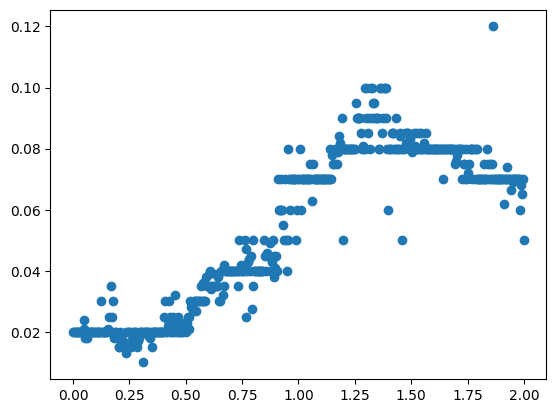

In [48]:
y = sub.devinfpoint.dropna().values
X = np.linspace(0, 2, len(y))[:,None]
plt.plot(X, y, linewidth=0, marker='o')

In [ ]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=1)
    eta = pm.HalfNormal("eta", sigma=5)

    cov = eta**2 * pm.gp.cov.ExpQuad(1, ell)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    sigma = pm.HalfNormal("sigma", sigma=2.0)
    nu = 1 + pm.Gamma(
        "nu", alpha=2, beta=0.1
    )  # add one because student t is undefined for degrees of freedom less than one
    obs = pm.Deterministic('obs', nu)
    y_ = pm.StudentT("y", mu=f, lam=1.0 / sigma, nu=nu, observed=y)

    idata_prior = pm.sample_prior_predictive()
    idata = pm.sample(1000, tune=1_000, chains=2)
    # idata = pm.sample(1000, tune=1000, chains=2, cores=2, nuts_sampler="numpyro")
    

Sampling: [ell, eta, f_rotated_, nu, sigma, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [ell, eta, f_rotated_, sigma, nu]


In [131]:
num_knots = int(X.shape[0] / 20)aaaa
knot_list = np.linspace(0, X.shape[0], num_knots+2)[1:-1]
num_knots

B = dmatrix(
    "bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
    {"cnt": [*range(0, X.shape[0])], "knots": knot_list[1:-1]})

with pm.Model() as infl_exp:
    τ = pm.HalfCauchy("τ", beta=1) 

    β = pm.Normal("β", mu=0, sigma=τ, shape=(B.shape[1], 1))
    μ = pm.Deterministic("μ", pm.math.dot(B.base, β))
    σ = pm.HalfNormal("σ", sigma=1)
    pm.Normal("likelihood", mu=μ, sigma=σ, observed=X)
    
    pi_e_prior = pm.sample_prior_predictive()
    pi_e_trace = pm.sample()
    pi_e_post = pm.sample_posterior_predictive(pi_e_trace)

Sampling: [likelihood, β, σ, τ]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.
Sampling: [likelihood]


''

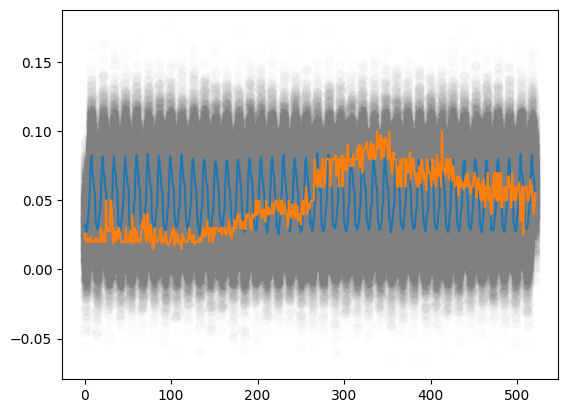

In [132]:
plt.plot(
    pi_e_post.posterior_predictive['likelihood'][:, get_samp(1_000, 10), :, :].values.reshape(X.shape[0],4*10*X.shape[1]),
    marker='o', linewidth=0, color='grey', alpha=.01
);
plt.plot(
    pi_e_post.posterior_predictive['likelihood'][:, get_samp(1_000, 10), :, :].values.reshape(X.shape[0],4*10*X.shape[1]).mean(axis=1),
)
plt.plot(np.median(X, axis=1))
;

In [133]:
# save

In [ ]:
fig = plt.figure(figsize=(14,4))
df[['pi_c_hhp_rm', 'pi_de_Y']].drop_duplicates().dropna().plot()
plt.title('Inflation perception vs. realised inflation in p.a.')
plt.legend(['perceived inflation', 'realised inflation'])
fig.savefig(os.path.join(GRAPHS_DIR, 'fig_p4_pi_pie.png'))

In [255]:
save_pd_df(df, 'hhp_processed.feather')

In [142]:
# Gaussian signal

$$ a(s) = \lambda s + (1-\lambda)x^d \quad \lambda = \frac{\sigma_x}{\sigma_x + \sigma_{\epsilon}}$$

In [143]:
## overall model

In [144]:
data = df[['pi_de_Y', 'pi_c_hhp_rm']].drop_duplicates().copy().dropna()
data['pi_c_hhp_rm'] -= .0199
pi_mu = (np.ones(len(data)) * df.pi_de_Y.loc[:data.index[0]].dropna().mean())

In [463]:
X, y = data.values[:,0], data.values[:,1]
with pm.Model() as mod1:
    lamb = pm.Beta('lambda', alpha=2, beta=2)
    # sigma = pm.HalfCauchy('simga', .1, 1)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = pm.Deterministic('mu', pi_mu * (1 - lamb) + lamb * X)
    
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
    
    mod1_prior = pm.sample_prior_predictive()

Sampling: [lambda, likelihood, sigma]


In [464]:
from src.utils import get_samp

''

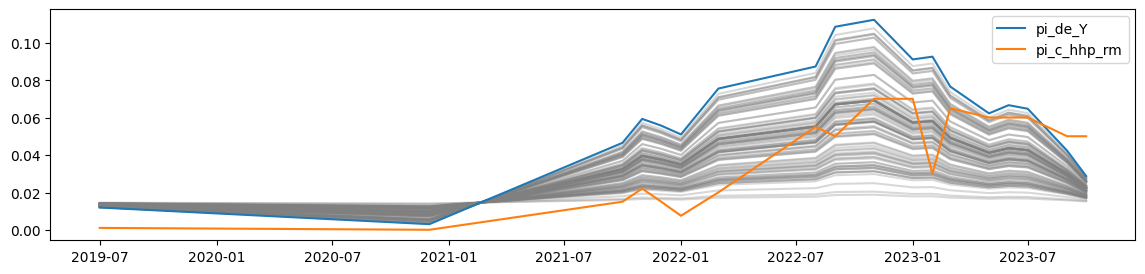

In [472]:
fig, ax = plt.subplots(1,1, figsize=(14,3))
ax.plot(
    data.index,
    mod1_prior.prior['mu'][0, get_samp(200)].T,
    alpha=.3, color='grey'
)
ax.plot(data, label=data.columns)
plt.legend()
;

In [471]:
with mod1:
    mod1_post = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


''

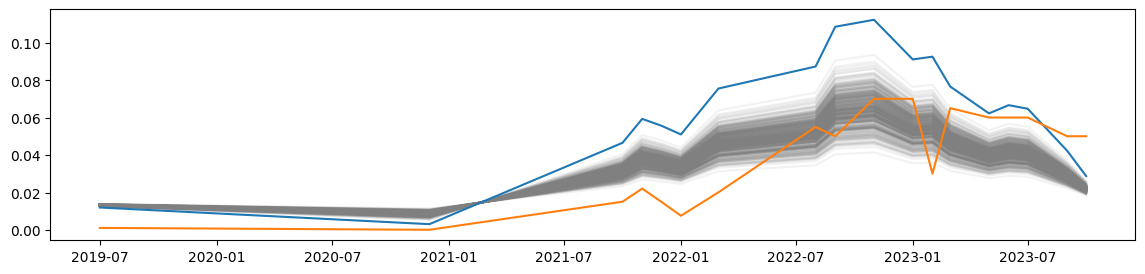

In [473]:
fig, ax = plt.subplots(1,1, figsize=(14,3))
ax.plot(
    data.index,
    mod1_post.posterior['mu'][:, get_samp(1000, 100)].values.reshape(400, data.shape[0]).T,
    alpha=.1,
    color='grey'
)
ax.plot(data)
;

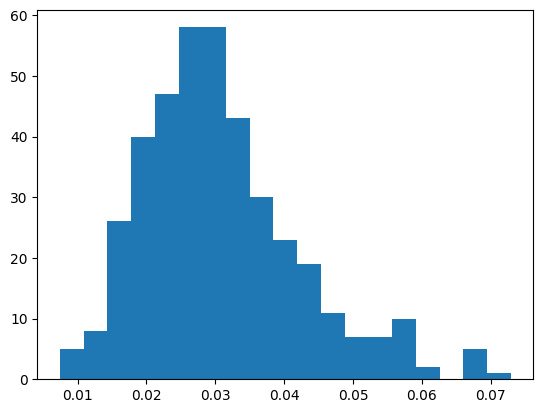

In [474]:
l = mod1_post.posterior['lambda'].values[:, get_samp(1_000)].reshape(400)
sigma_e = X.std() * (1 - l) / l
plt.hist(sigma_e, bins='fd');
# plt.hist(l, bins='fd');

In [145]:
## get panel dimension lambda

In [146]:
# pivot to date pi_e
sub = df.reset_index().rename(columns={'index': 'date_recorded'}).set_index('id').copy()
sub = sub.pivot_table(index='date_recorded', columns='id', values='pi_e_hhp').copy()

# drop all cols with less than 13 obs
sub = sub.loc[:, sub.count() >= 13].copy().reset_index() #.set_index('M').drop('date_recorded', axis=1).copy()
sub = sub.loc[sub.iloc[:,1:-1].dropna(thresh=1).index]

# join pi_de
sub['M'] = sub.date_recorded.dt.to_period('M').dt.to_timestamp()
infl['M'] = infl.index.to_period('M').to_timestamp()
sub = pd.merge(sub, infl[['pi_de_Y', 'M']], on='M')

sub = sub.set_index('M').drop(['date_recorded'], axis=1)

In [147]:
A = sub.iloc[:,:-1].copy()
A = A.iloc[:, :80]

pi_mean = infl.loc[sub.index.min()-timedelta(days=365): sub.index.min()].pi_de_surprise_Y.mean()
pi_mean = np.ones(A.shape) * pi_mean

In [148]:
pi_perceived = [list(A[x].dropna().values) for x in A]
pi_perceived = np.array([ x + list([0] * (A.count().max() - len(x))) for x in pi_perceived]).T

In [149]:
pi_real = [list(sub.iloc[:,-1].values[list(A.reset_index(drop=True)[x].dropna().index)]) for x in A]
pi_real = np.array([x + list([0] * (A.count().max() - len(x))) for x in pi_real]).T

In [150]:
pi_mean = infl.loc[sub.index.min()-timedelta(days=365): sub.index.min()].pi_de_surprise_Y.mean()
pi_mean = np.ones(pi_perceived.shape) * pi_mean

In [151]:
rho = .87
with pm.Model() as mod2:
    
    alpha_lamb = pm.Gamma("alpha_lamb", alpha=.8, beta=.5)
    beta_lamb = pm.Gamma("beta_lamb", alpha=2, beta=.5)
        
    lamb = pm.Beta('lambda', alpha_lamb, beta_lamb, shape=pi_perceived.shape[1])
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    mu = pm.Deterministic('mu', pi_real * lamb  + pi_mean * (1 - lamb))
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=pi_perceived)
    
    mod2_prior = pm.sample_prior_predictive()

Sampling: [alpha_lamb, beta_lamb, lambda, likelihood, sigma]


''

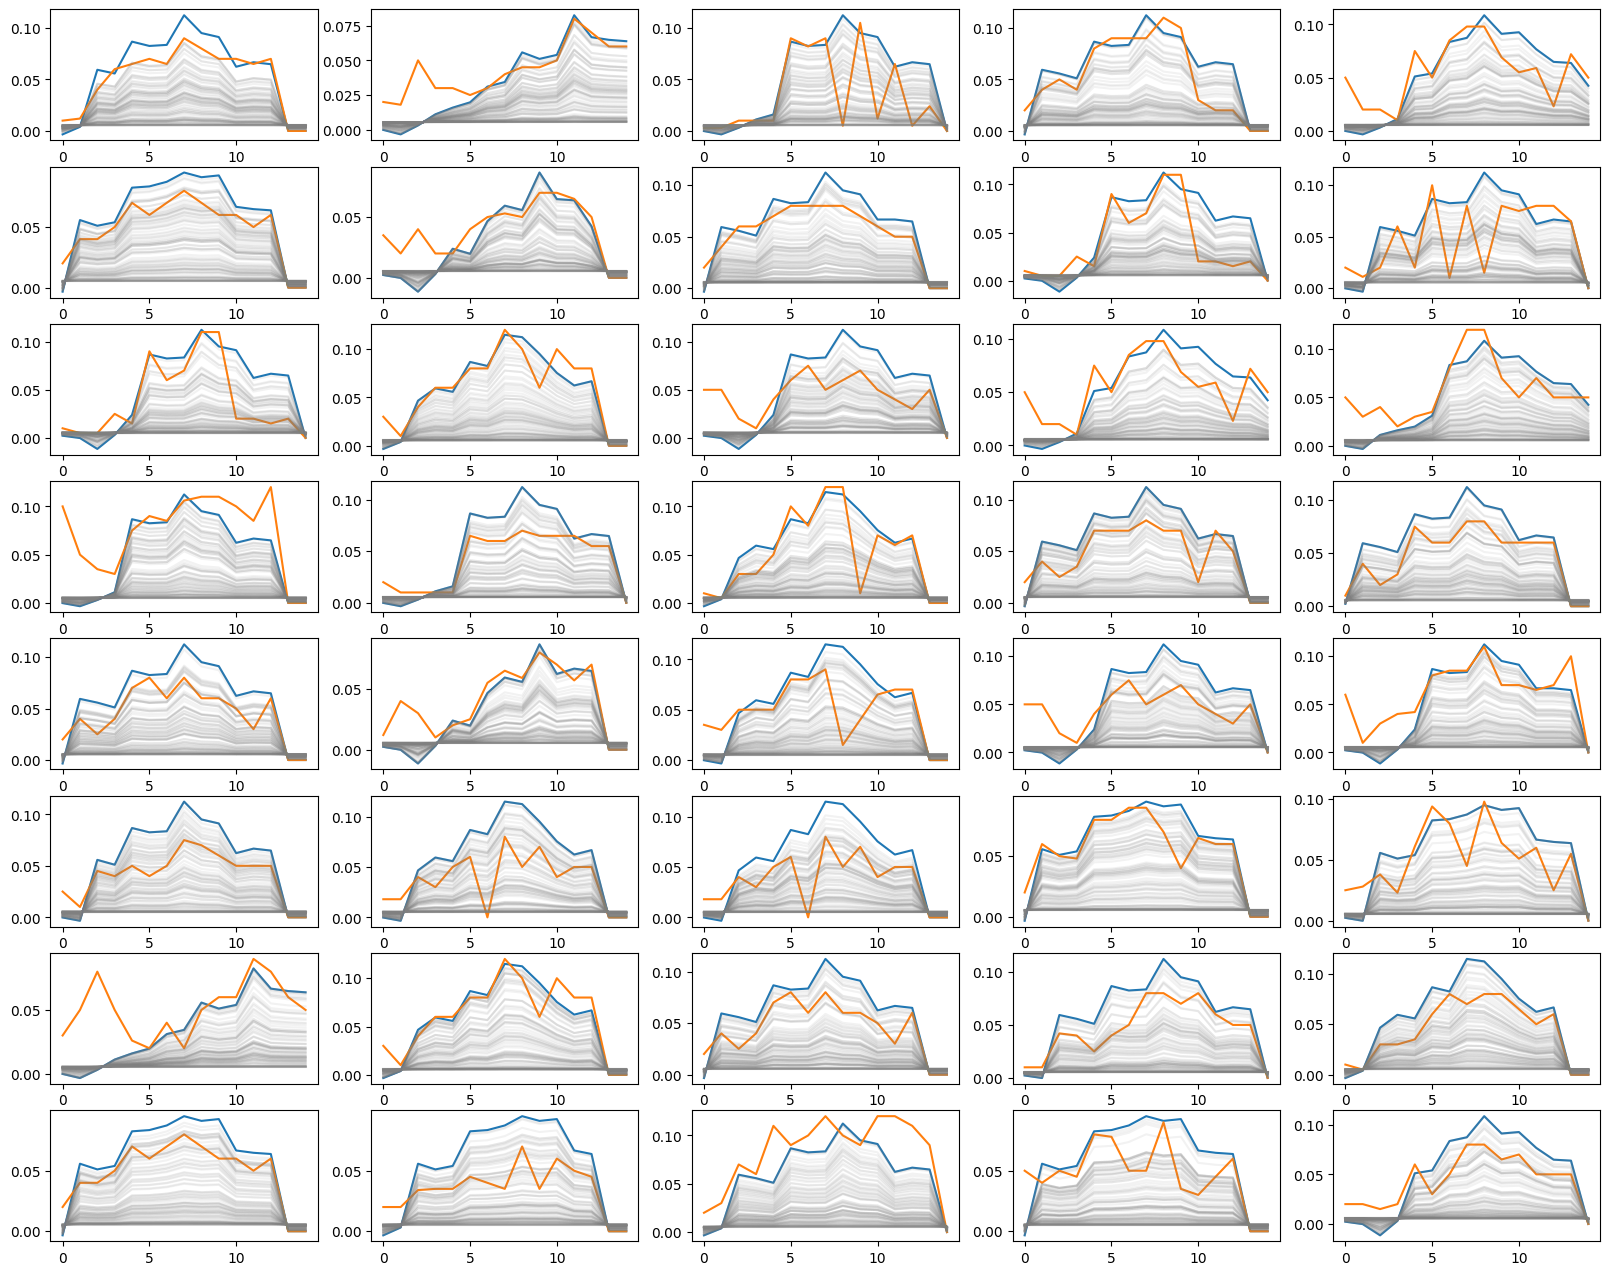

In [152]:
N = 40
cols = 5
fig, axes = plt.subplots(int(np.ceil(N/cols)), cols, figsize=(20, np.ceil(N/cols) * 2))
for i, ax in zip(np.random.randint(0, pi_perceived.shape[1], min(pi_perceived.shape[1], N)), axes.ravel()):
    ax.plot(pi_real[:,i].T)
    ax.plot(pi_perceived[:, i].T)
    ax.plot(mod2_prior.prior['mu'].values[0, get_samp(500), :, i].T, alpha=.1, color='grey'),
;

In [153]:
with mod2:
    mod2_post = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_lamb, beta_lamb, lambda, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.


''

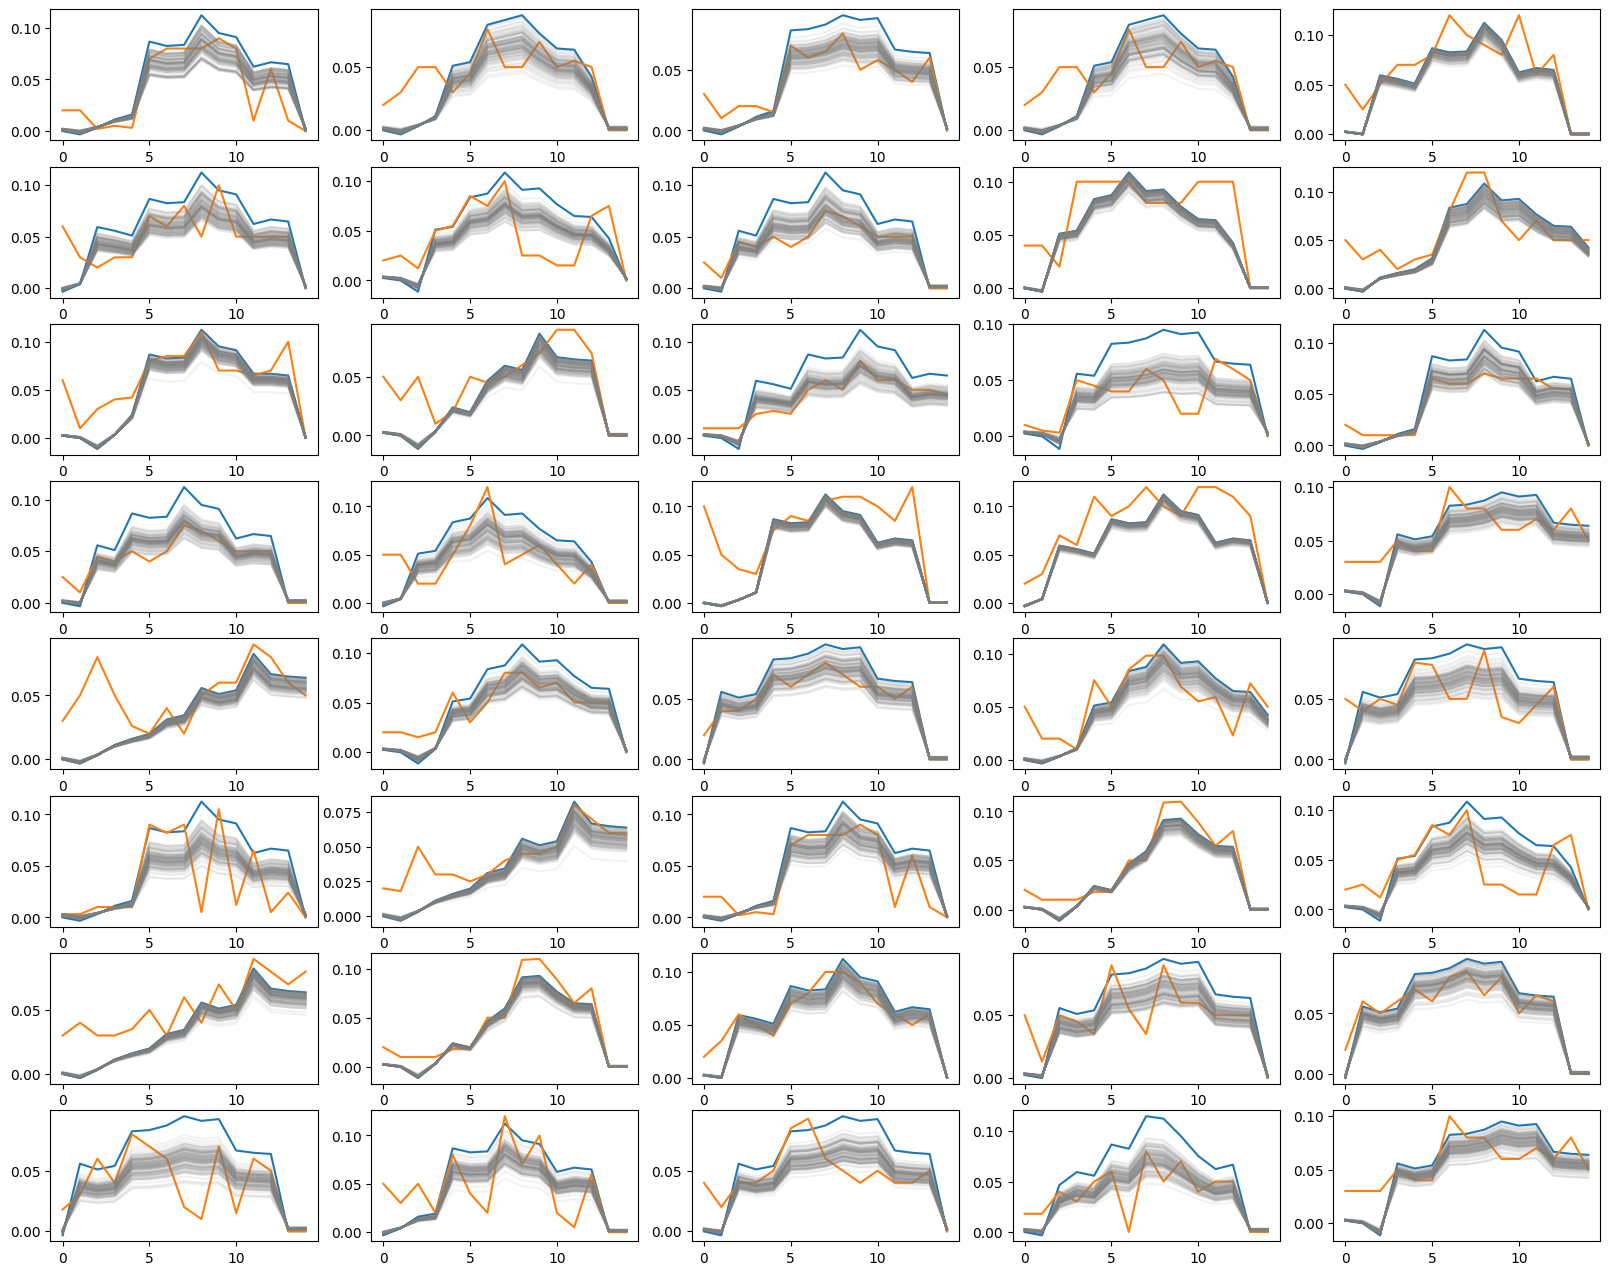

In [154]:
N = 40
cols = 5
fig, axes = plt.subplots(int(np.ceil(N/cols)), cols, figsize=(20, np.ceil(N/cols) * 2))
for i, ax in zip(np.random.randint(0, pi_perceived.shape[1], min(pi_perceived.shape[1], N)), axes.ravel()):
    ax.plot(pi_real[:,i].T)
    ax.plot(pi_perceived[:, i].T)
    ax.plot(mod2_post.posterior['mu'].values[0, get_samp(500), :, i].T, alpha=.1, color='grey'),
;

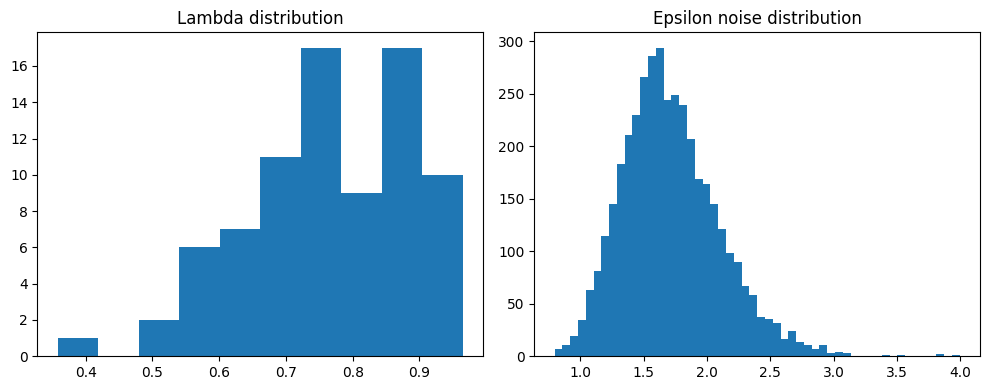

In [219]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(mod2_post.posterior['lambda'].values.reshape(4_000, A.shape[1]).mean(axis=0))
ax[1].hist(mod2_post.posterior['beta_lamb'].values.reshape(4_000), bins='fd')
# ax[1].axvline(pi_real.std(), color='red')

ax[0].set_title('Lambda distribution')
ax[1].set_title('Epsilon noise distribution')
plt.tight_layout()
fig.savefig(os.path.join(GRAPHS_DIR, 'fig_p4_pie_lambda_epsilon.png'))

# Calvo model

## calvo model fixed rho

$$ a_{t,0} = (1 - \beta \theta) \sum_{s=0}^\inf \beta^s \theta^s \mathbb{E}_t [x_{t+s}] = \frac{1-\beta \theta}{1-\beta \theta \rho} x_t $$
$$ x_{t+1} = \rho x_t + \epsilon_t $$

In [236]:
# pivot to date pi_e
sub = df.reset_index().rename(columns={'index': 'date_recorded'}).set_index('id').copy()
sub = sub.pivot_table(index='date_forecast', columns='id', values='pi_e_hhp').copy()

# get date recoreded
_ = df.date_forecast.dropna().drop_duplicates()
sub['date_recorded'] = sub.index.map(dict(zip(list(_.values), list(_.index))))

# drop all cols with less than 13 obs
sub = sub.loc[:, sub.count() >= 13].copy().reset_index() #.set_index('M').drop('date_recorded', axis=1).copy()
sub = sub.loc[sub.iloc[:,1:-1].dropna(thresh=1).index]

# join pi_de
sub['M'] = sub.date_recorded.dt.to_period('M').dt.to_timestamp()
infl['M'] = infl.index.to_period('M').to_timestamp()
sub = pd.merge(sub, infl[['pi_de_Y', 'M']], on='M')

sub = sub.set_index('M').drop(['date_recorded', 'date_forecast'], axis=1)

In [237]:
A = sub.iloc[:,:-1].copy()
A = A.iloc[:, :80]

pi_mean = infl.loc[sub.index.min()-timedelta(days=365): sub.index.min()].pi_de_surprise_Y.mean()
pi_mean = np.ones(A.shape) * pi_mean

In [238]:
forecast = [list(A[x].dropna().values) for x in A]
_ = [len(i) for i in forecast]
forecast = np.array([ x + list([0] * (A.count().max() - len(x))) for x in forecast]).T

In [239]:
pi_real = [list(sub.iloc[:,-1].values[list(A.reset_index(drop=True)[x].dropna().index)]) for x in A]
pi_real = np.array([x + list([0] * (A.count().max() - len(x))) for x in pi_real]).T

In [240]:
# from statsmodels.tsa.arima.model import ARIMA
# plt.plot(infl.pi_de_surprise_Y)
# ARIMA(inlf.pi_de_surprise_Y.dropna().values, order=(1,0,0)).fit().summary()

# theta, beta = .9, .9
# plt.plot([(1 - theta*beta)/(1 - theta*beta*rho) for rho in np.linspace(0.01, 1.2,  100)])

In [244]:
from statsmodels.tsa.arima.model import ARIMA
ar = ARIMA(infl.loc[:A.index.min()].pi_de_Y.dropna().values, order=(1,0,0)).fit()
ar.summary()
rho = ar.params[1]

with pm.Model() as mod3:
    
    alpha_phi = pm.Gamma("alpha_phi", alpha=.8, beta=.5)
    beta_phi = pm.Gamma("beta_phi", alpha=2, beta=.5)
    
    phi = pm.Beta('phi', alpha_phi, beta_phi, shape=forecast.shape[1])
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    mu = pm.Deterministic('mu', pi_real * (1 - phi)/(1 - phi * rho))
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=forecast)
    
    mod3_prior = pm.sample_prior_predictive()

Sampling: [alpha_phi, beta_phi, likelihood, phi, sigma]


''

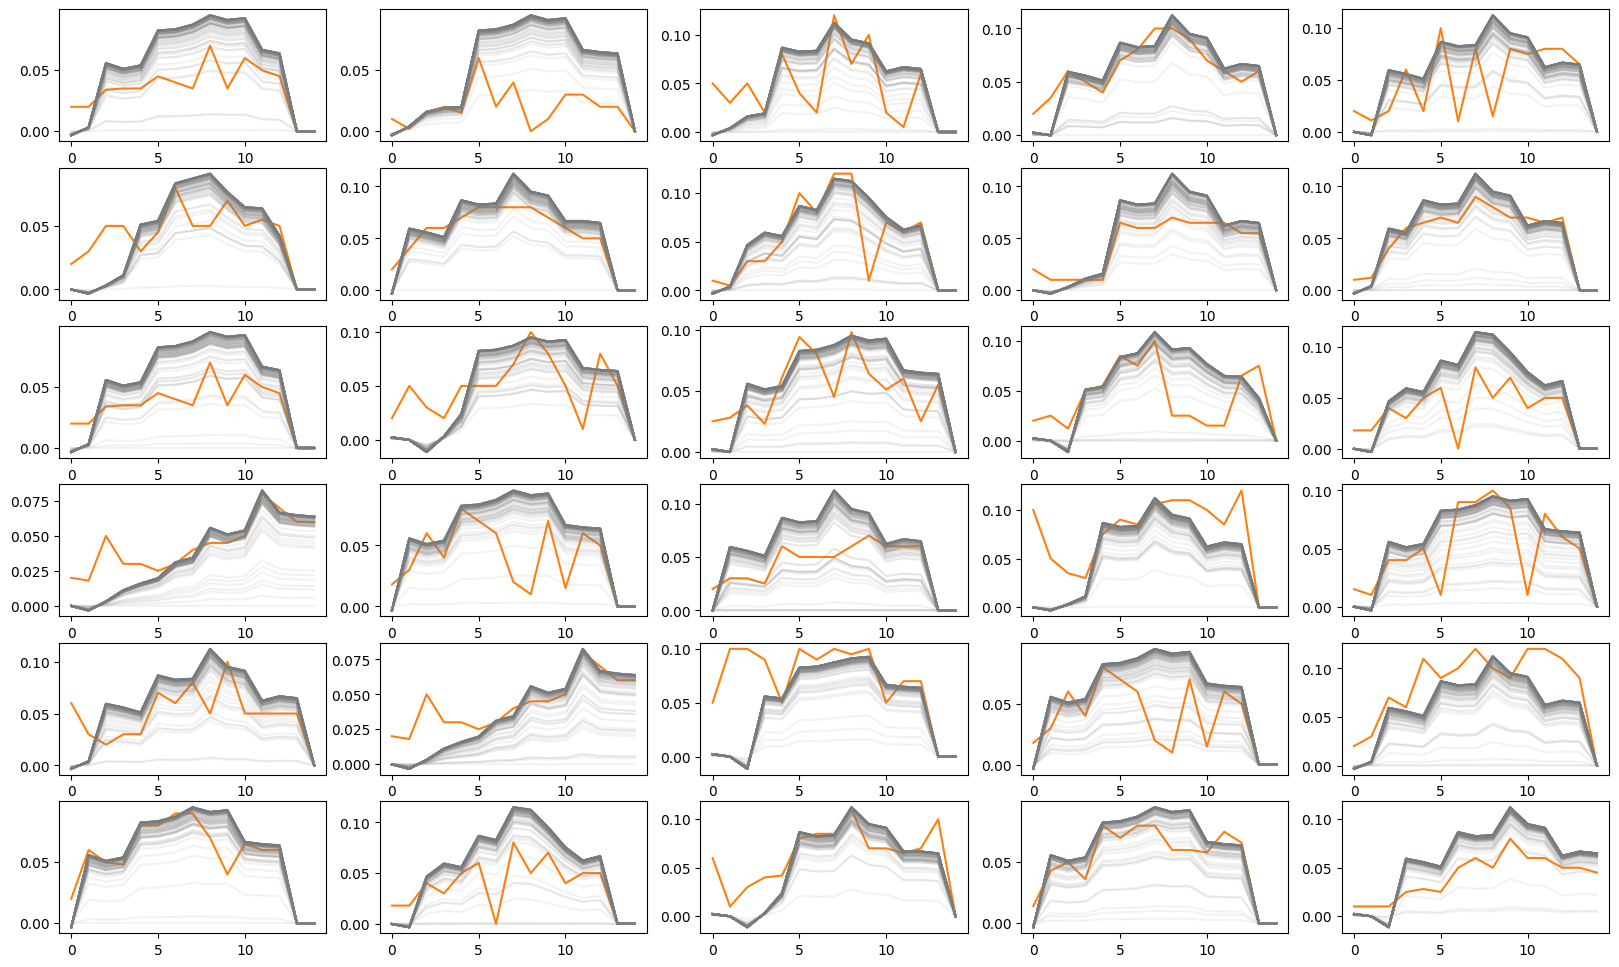

In [245]:
N = 30
cols = 5
fig, axes = plt.subplots(int(np.ceil(N/cols)), cols, figsize=(20, np.ceil(N/cols) * 2))
for i, ax in zip(np.random.randint(0, forecast.shape[1], min(forecast.shape[1], N)), axes.ravel()):
    ax.plot(pi_real[:,i].T)
    ax.plot(forecast[:, i].T)
    ax.plot(mod3_prior.prior['mu'].values[0, get_samp(500), :, i].T, alpha=.1, color='grey'),
;

In [246]:
with mod3:
    mod3_post = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_phi, beta_phi, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.


''

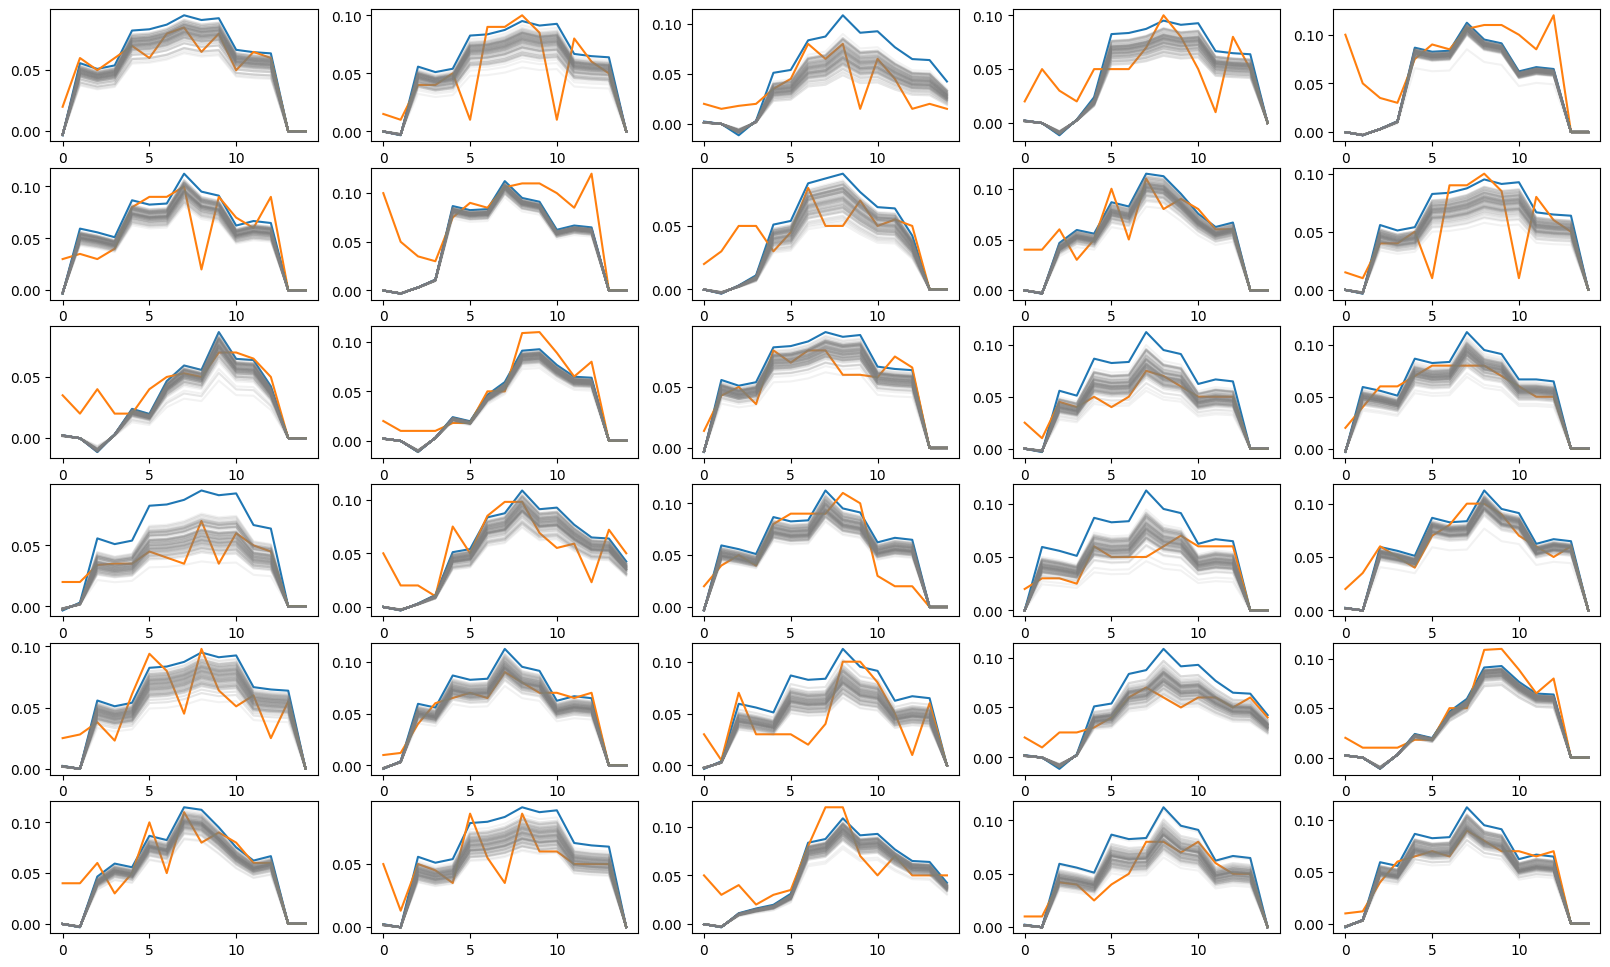

In [249]:
N = 30
cols = 5
fig, axes = plt.subplots(int(np.ceil(N/cols)), cols, figsize=(20, np.ceil(N/cols) * 2))
for i, ax in zip(np.random.randint(0, forecast.shape[1], min(forecast.shape[1], N)), axes.ravel()):
    ax.plot(pi_real[:,i].T)
    ax.plot(forecast[:, i].T)
    ax.plot(mod3_post.posterior['mu'].values[0, get_samp(500), :, i].T, alpha=.1, color='grey'),
;

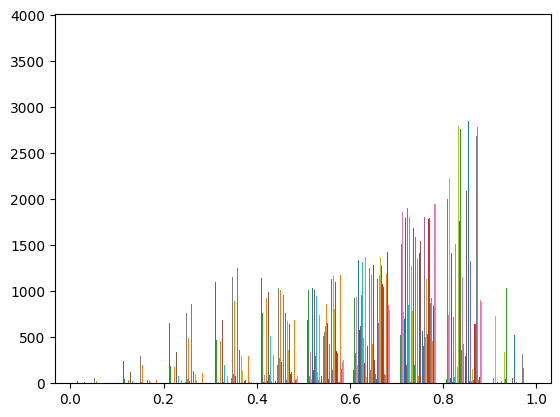

In [254]:
plt.hist(mod3_post.posterior['phi'].values.reshape(4_000, A.shape[1]));

## calvo phi and rho

In [250]:
with pm.Model() as mod3_1:
    
    alpha_phi = pm.Gamma("alpha_phi", alpha=.8, beta=.5)
    beta_phi = pm.Gamma("beta_phi", alpha=2, beta=.5)
    
    alpha_rho = pm.Gamma("alpha_rho", alpha=.8, beta=.5)
    beta_rho = pm.Gamma("beta_rho", alpha=2, beta=.5)
    
    phi = pm.Beta('phi', alpha_phi, beta_phi, shape=forecast.shape[1])
    rho = pm.Gamma('rho', alpha_rho, beta_rho, shape=forecast.shape[1])
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    mu = pm.Deterministic('mu', pi_real * (1 - phi)/(1 - phi * rho))
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=forecast)
    
    mod3_1_prior = pm.sample_prior_predictive()

Sampling: [alpha_phi, alpha_rho, beta_phi, beta_rho, likelihood, phi, rho, sigma]


''

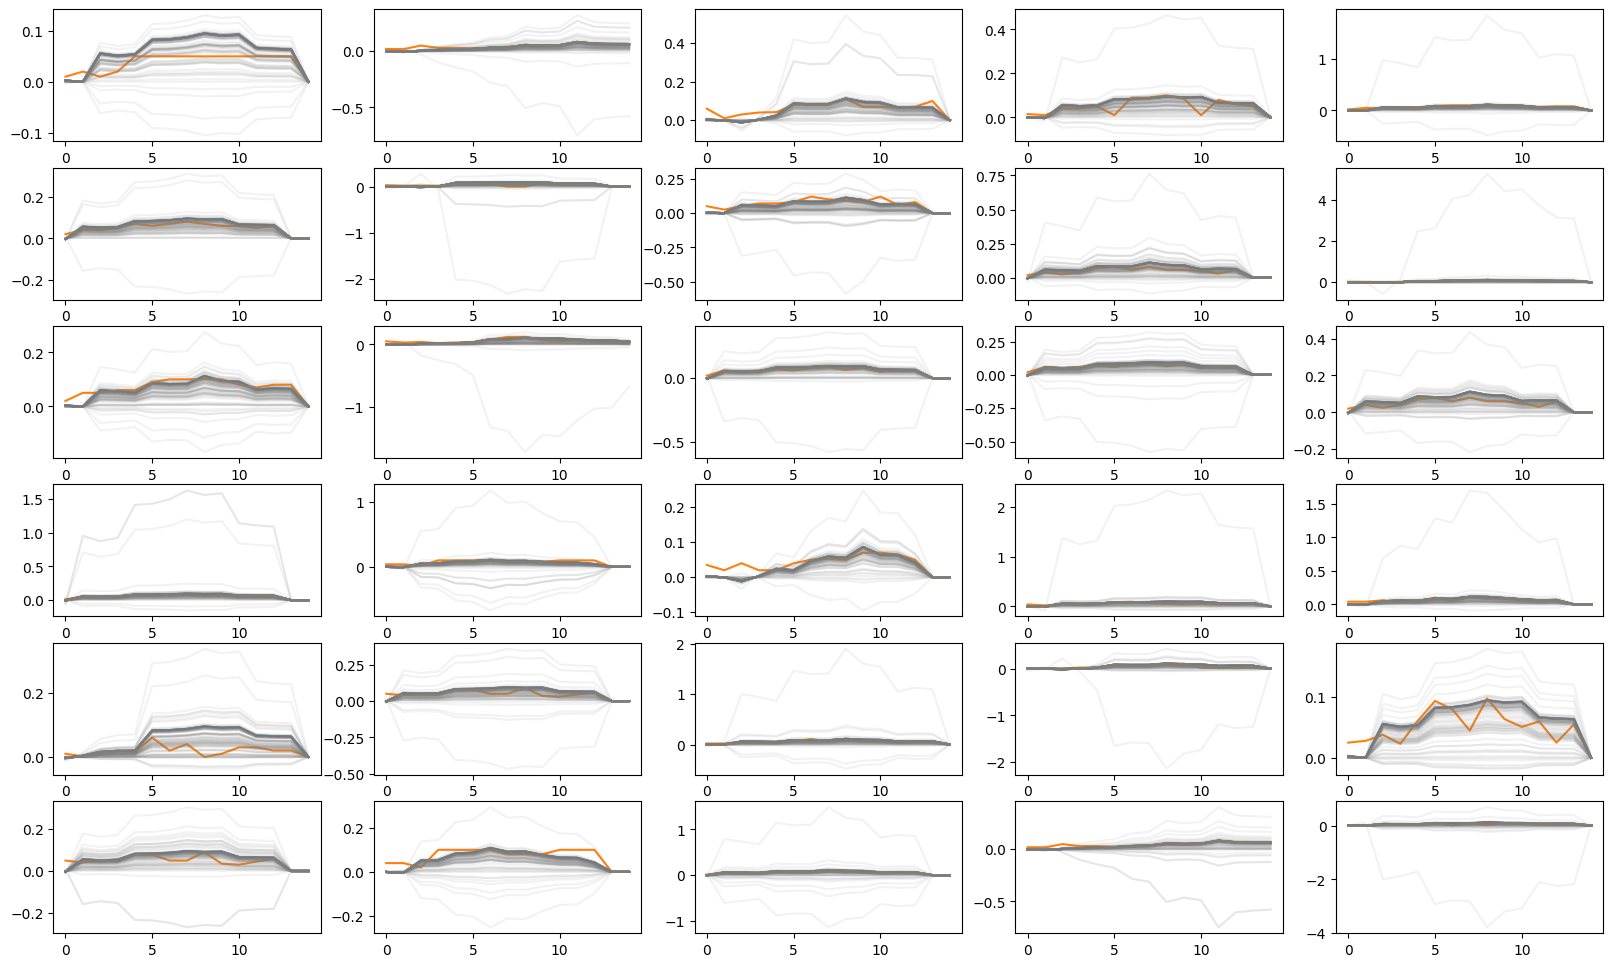

In [251]:
N = 30
cols = 5
fig, axes = plt.subplots(int(np.ceil(N/cols)), cols, figsize=(20, np.ceil(N/cols) * 2))
for i, ax in zip(np.random.randint(0, forecast.shape[1], min(forecast.shape[1], N)), axes.ravel()):
    ax.plot(pi_real[:,i].T)
    ax.plot(forecast[:, i].T)
    ax.plot(mod3_1_prior.prior['mu'].values[0, get_samp(500), :, i].T, alpha=.1, color='grey'),
;

In [252]:
with mod3_1:
    mod3_1_post = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_phi, beta_phi, alpha_rho, beta_rho, phi, rho, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 924 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


''

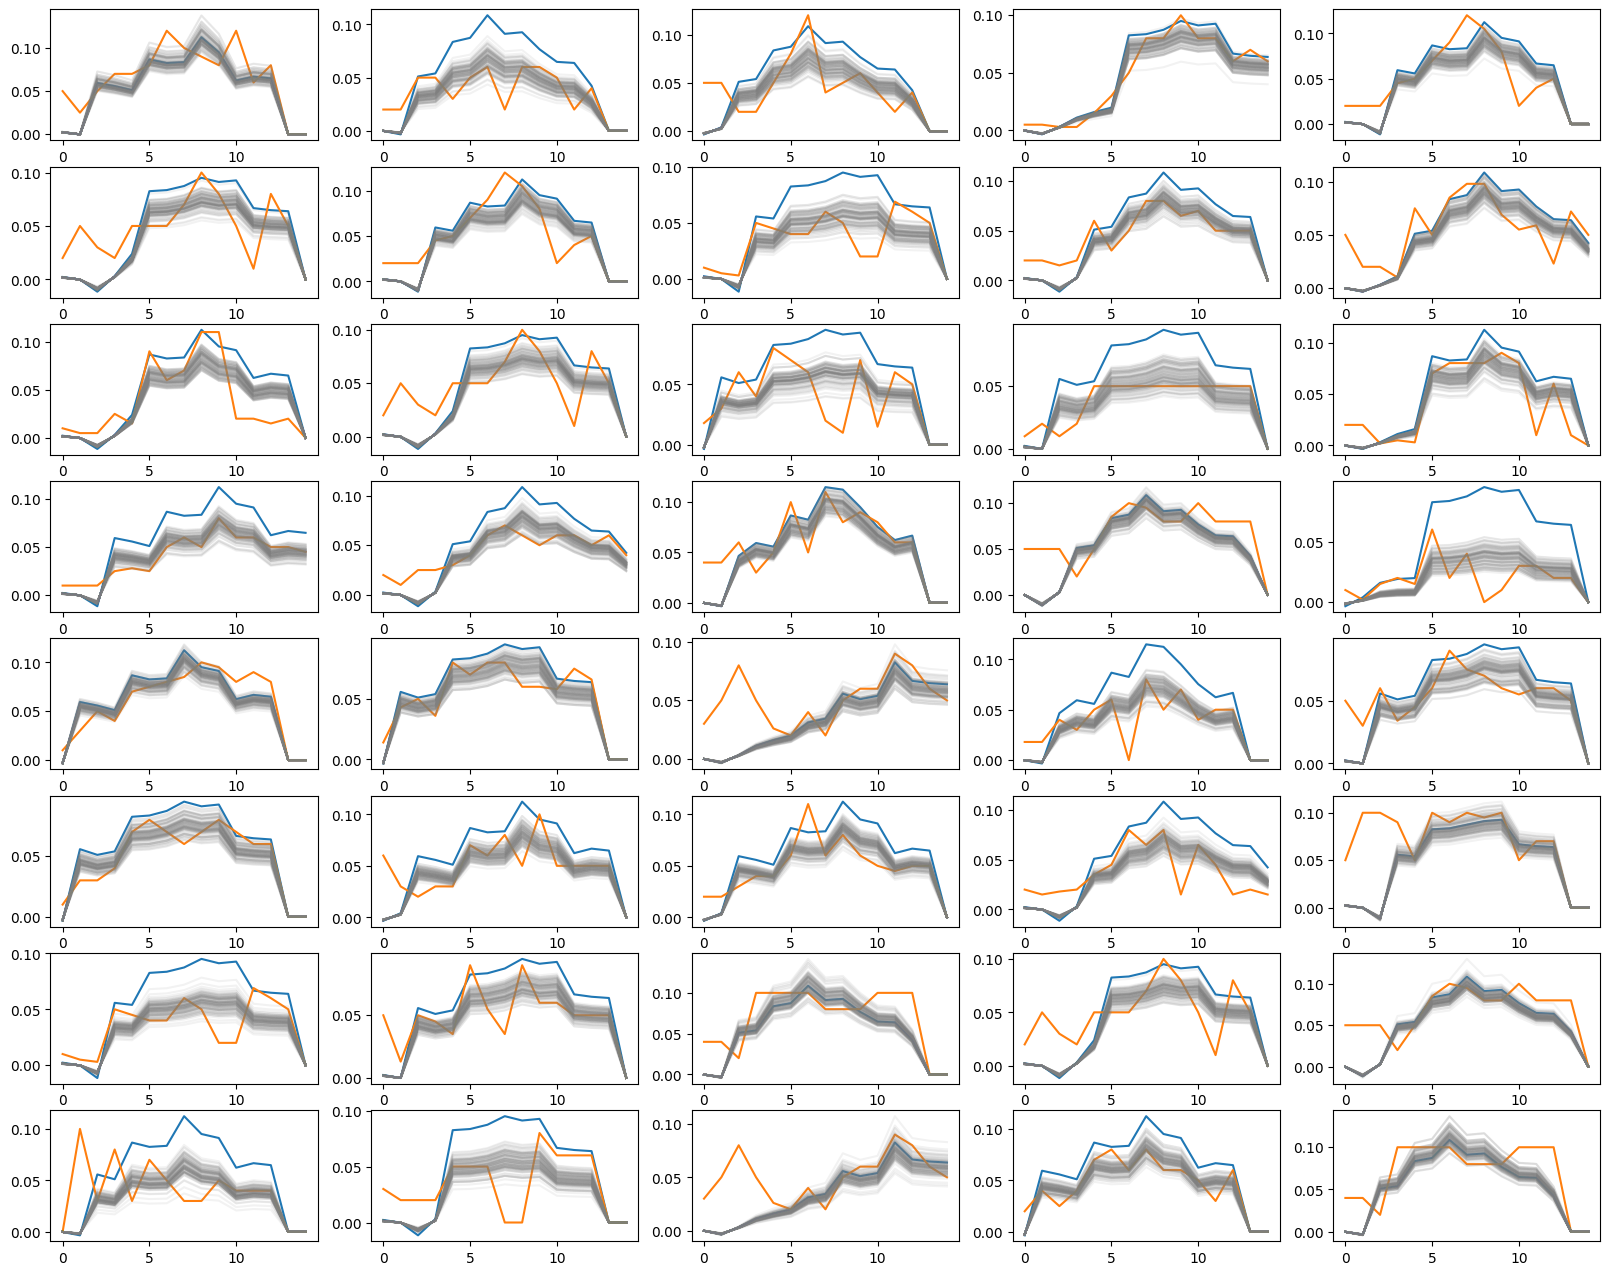

In [256]:
N = 40
cols = 5
fig, axes = plt.subplots(int(np.ceil(N/cols)), cols, figsize=(20, np.ceil(N/cols) * 2))
for i, ax in zip(np.random.randint(0, forecast.shape[1], min(forecast.shape[1], N)), axes.ravel()):
    ax.plot(pi_real[:,i].T)
    ax.plot(forecast[:, i].T)
    ax.plot(mod3_1_post.posterior['mu'].values[0, get_samp(500), :, i].T, alpha=.1, color='grey'),
;

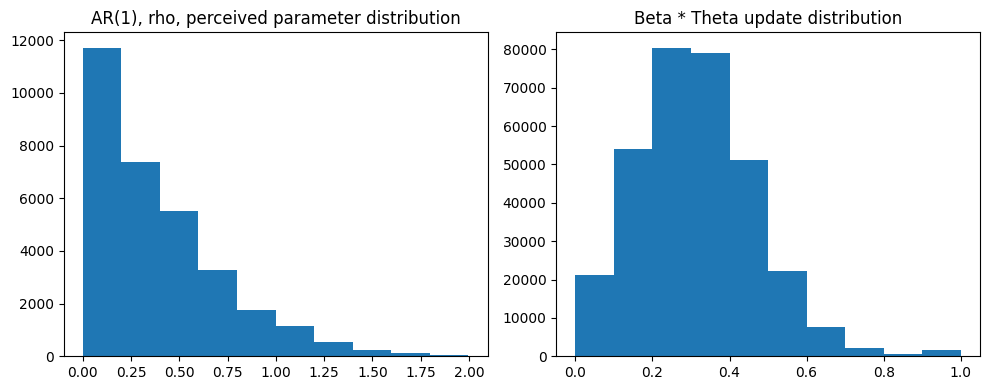

In [284]:
arr = mod3_1_post.posterior['rho'][:, get_samp(1_000), :].values.reshape(400, A.shape[1])

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(arr[arr<=2])
ax[1].hist(mod3_1_post.posterior['phi'].values.ravel())

ax[0].set_title('AR(1), rho, perceived parameter distribution')
ax[1].set_title('Beta * Theta update distribution')
plt.tight_layout()
fig.savefig(os.path.join(GRAPHS_DIR, 'p4_beta_theta.png'))

# analyse panel

In [54]:
sub = hhp.pivot_table(index='date_forecast', columns='id', values='pi_hhp').copy()
sub['M'] = sub.index.to_period('M')

sub = pd.merge(sub.reset_index(), infl[['pi_de_Y', 'M']].copy(), on='M', how='left').drop('M', axis=1).set_index('date_forecast')
sub = sub.loc[sub['pi_de_Y'].dropna().index]
sub = sub.loc[:, sub.count(axis=0) > 8]

sub.shape

(424, 2078)

In [56]:
sub_reg = sub.copy()

for col in sub.drop('pi_de_Y', axis=1).columns:
    srs = sub[col].dropna().copy()
    resid = OLS(srs, sub.loc[srs.index, 'pi_de_Y']).fit().resid
    
    sub_reg.loc[srs.index, col] = resid

sub_reg.drop('pi_de_Y', axis=1, inplace=True)

_ = sub_reg.apply(lambda x: (x.dropna() ** 2).mean()).sort_values().copy()
idx, mse = _.index, _.values

''

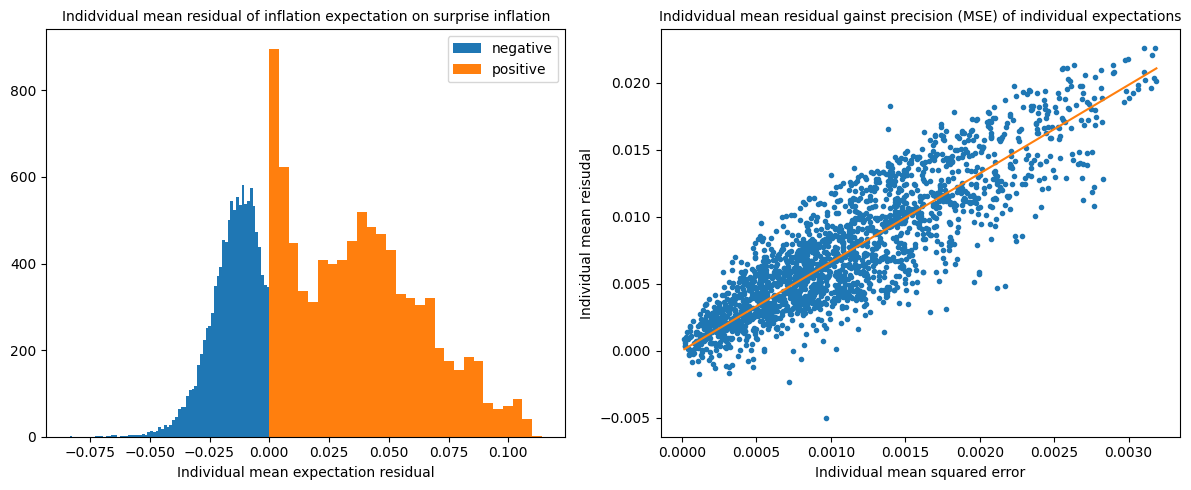

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
arr_n = sub_reg[sub_reg < 0].values.ravel()
arr_p = sub_reg[sub_reg > 0].values.ravel()

arr_n = arr_n[~np.isnan(arr_n)]
arr_p = arr_p[~np.isnan(arr_p)]

ax[0].hist(arr_n, bins='fd')
ax[0].hist(arr_p, bins='fd')

ax[0].legend(['negative', 'positive'])
ax[0].set_xlabel('Individual mean expectation residual')

N = 30
ax[1].plot(mse[:-N], sub_reg.loc[:, idx].mean().values[:-N], linewidth=0, marker='.')
ax[1].plot(mse[:-N], OLS(sub_reg.loc[:, idx].mean().values[:-N], mse[:-N]).fit().fittedvalues)
ax[1].set_xlabel('Individual mean squared error')
ax[1].set_ylabel('Individual mean reisudal')

ax[0].set_title('Indidvidual mean residual of inflation expectation on surprise inflation', size=10)
ax[1].set_title('Indidvidual mean residual gainst precision (MSE) of individual expectations', size=10)

plt.tight_layout()
fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_pi_resid.png'))
;
